In [1]:
import tensorflow as tf
import numpy as np
import math
from google.colab import drive
import pickle
from tensorflow.contrib import ffmpeg
from scipy.fftpack import rfft, irfft
drive.mount('/content/drive',force_remount=True)
import glob
import os

Mounted at /content/drive


# Create Data

In [2]:


"""

train_wav_paths=[]
for x in glob.glob('/content/drive/My Drive/DLSP/TIMIT_full/train/*/*/*_riff.wav', recursive=True):
    train_wav_paths.append(x)

test_wav_paths=[]
for x in glob.glob('/content/drive/My Drive/DLSP/TIMIT_full/test/*/*/*_riff.wav', recursive=True):
    test_wav_paths.append(x)

    
training_data_speaker_label=[]
training_data=[] #contains sound samples

def create_data(path_arr):
  for i in range(0,len(path_arr)):
    binary=tf.read_file(path_arr[i])
    decode=tf.audio.decode_wav(binary,desired_channels=1)
    audio,sr=sess.run([decode.audio,decode.sample_rate])
    audio=np.array(audio)
    #print(np.shape(audio))
    audio_rfft=rfft(audio[:,0])
    dim_one=math.floor(len(audio_rfft)/input_dimension)
    total_len=dim_one*input_dimension
    final_audio=audio_rfft[0:total_len].reshape([dim_one,input_dimension])
    print(np.shape(final_audio))
    training_data.append(final_audio)
    speaker_name=os.path.dirname(path_arr[i]).split('/')[-1]
    training_data_speaker_label.append(speaker_name)
    print(speaker_name)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  create_data(train_wav_paths)

data = [training_data_speaker_label, training_data]
pickle_out = open("/content/drive/My Drive/DLSP/train_data_speaker_data.pickle","wb")
pickle.dump(data, pickle_out)
pickle_out.close()
"""

'\n\ntrain_wav_paths=[]\nfor x in glob.glob(\'/content/drive/My Drive/DLSP/TIMIT_full/train/*/*/*_riff.wav\', recursive=True):\n    train_wav_paths.append(x)\n\ntest_wav_paths=[]\nfor x in glob.glob(\'/content/drive/My Drive/DLSP/TIMIT_full/test/*/*/*_riff.wav\', recursive=True):\n    test_wav_paths.append(x)\n\n    \ntraining_data_speaker_label=[]\ntraining_data=[] #contains sound samples\n\ndef create_data(path_arr):\n  for i in range(0,len(path_arr)):\n    binary=tf.read_file(path_arr[i])\n    decode=tf.audio.decode_wav(binary,desired_channels=1)\n    audio,sr=sess.run([decode.audio,decode.sample_rate])\n    audio=np.array(audio)\n    #print(np.shape(audio))\n    audio_rfft=rfft(audio[:,0])\n    dim_one=math.floor(len(audio_rfft)/input_dimension)\n    total_len=dim_one*input_dimension\n    final_audio=audio_rfft[0:total_len].reshape([dim_one,input_dimension])\n    print(np.shape(final_audio))\n    training_data.append(final_audio)\n    speaker_name=os.path.dirname(path_arr[i]).split

In [0]:
# Create data if not already created using above cell

pickle_in = open("/content/drive/My Drive/DLSP/train_data_speaker_data.pickle","rb")
training_data_speaker_label, training_data = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/DLSP/test_data_speaker_data.pickle","rb")
test_data_speaker_label, test_data = pickle.load(pickle_in)

# Model and Training

In [0]:
import keras
from keras.optimizers import Adam
from keras.layers import Dense
from keras.models import Sequential
from sklearn.utils import shuffle
from keras import regularizers
from tensorflow.contrib import ffmpeg

print(len(training_data))
training_data = shuffle(training_data, random_state=1)
print(len(training_data))
validation_data= training_data[-460:]
print(len(training_data))
training_data=training_data[:-460]
print(len(training_data))
print(len(validation_data))


lr = 0.000001
l2 = 0.0001
input_size=12348

INPUT = tf.placeholder(tf.float32, shape=[None, input_size])
l2_regularizer = tf.contrib.layers.l2_regularizer(l2)

Hidden_Layer_1=tf.layers.dense(INPUT, 8500, activation=tf.nn.elu, kernel_initializer=tf.contrib.layers.variance_scaling_initializer(), kernel_regularizer=tf.contrib.layers.l2_regularizer(l2))
Hidden_Layer_2=tf.layers.dense(Hidden_Layer_1, 3500, activation=tf.nn.elu, kernel_initializer=tf.contrib.layers.variance_scaling_initializer(), kernel_regularizer=tf.contrib.layers.l2_regularizer(l2))
Hidden_Layer_3=tf.layers.dense(Hidden_Layer_2, 2750, activation=tf.nn.elu, kernel_initializer=tf.contrib.layers.variance_scaling_initializer(), kernel_regularizer=tf.contrib.layers.l2_regularizer(l2))
Hidden_Layer_4=tf.layers.dense(Hidden_Layer_3, 3500, activation=tf.nn.elu, kernel_initializer=tf.contrib.layers.variance_scaling_initializer(), kernel_regularizer=tf.contrib.layers.l2_regularizer(l2))
outputs = tf.layers.dense(Hidden_Layer_4, input_size, activation=None, kernel_initializer=tf.contrib.layers.variance_scaling_initializer(), kernel_regularizer=tf.contrib.layers.l2_regularizer(l2))

reg_cost = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
rec_cost = tf.reduce_mean(tf.square(outputs-INPUT))
loss_ = tf.add_n(reg_cost+[rec_cost])
optimizer = tf.train.AdamOptimizer(lr)
training_op = optimizer.minimize(loss_)

curr_batch=0




saver = tf.train.Saver(max_to_keep=2)
sess=tf.Session()
sess.run(tf.global_variables_initializer())
#saver.restore(sess,"/content/drive/My Drive/DLSP/Final_Model_Saved_File/Final_Model.ckpt")
train_update_loss=[]
validation_loss=[]

for epoch in range(0,1000):
  
  if curr_batch+50>=len(training_data):
    curr_batch=0
  
  for i in range(curr_batch,curr_batch+50):
    print(np.shape(training_data[i]))
    _, loss=  sess.run([training_op, loss_], feed_dict={INPUT:training_data[i]}) #change
    train_update_loss.append(loss)
    print("epoch-",epoch," example-",i," loss-",loss)
  
  curr_batch+=50
  
  # Calculating Validation is impossible, as there are too many validation files and too small time window on colab
  if epoch%20==0:
    print("checking_validation-")
    epoch_validation_loss=[]
    #for item in validation_data:
    #  val_loss=sess.run([loss_], feed_dict={INPUT:item})  #change
    #  print("validation_loss on example-",val_loss)
    #  epoch_validation_loss.append(val_loss)
    #print("\n the validation loss is-",np.mean(epoch_validation_loss),"\n")
    #validation_loss.append(np.mean(epoch_validation_loss))

    data = train_update_loss
    pickle_out = open("/content/drive/My Drive/DLSP/result_from_final_model_update_loss_valid_loss-2.pickle","wb")
    pickle.dump(data, pickle_out)
    pickle_out.close()

  if epoch%20==0 and epoch!=0:
    print("check if got in")
    saver.save(sess,"/content/drive/My Drive/DLSP/Final_Model_Saved_File/Final_Model.ckpt")
    original=np.hstack(np.hstack(test_data[0]))
    generated=sess.run(outputs, feed_dict={INPUT:test_data[0]})
    #print("check")
    generated=np.hstack(np.hstack(generated))
    original=np.hstack(irfft(original))
    generated=np.hstack(irfft(generated))
    original=np.array([original]).T
    generated=np.array([generated]).T
    print(generated)
    wav_encoder_generated = ffmpeg.encode_audio(generated, file_format='wav', samples_per_second=16000)
    wav_encoder_original = ffmpeg.encode_audio(original, file_format='wav', samples_per_second=16000)
    
    wav_generated = sess.run(wav_encoder_generated)
    wav_original = sess.run(wav_encoder_original)
    open('/content/drive/My Drive/DLSP/Final_Model_Test_Files/generated.wav', 'wb').write(wav_generated)
    open('/content/drive/My Drive/DLSP/Final_Model_Test_Files/original.wav', 'wb').write(wav_original)  
  

In [0]:
for i in range(0,len(test_data)):
  original=np.hstack(np.hstack(test_data[i]))
  generated=sess.run(outputs, feed_dict={INPUT:test_data[i]})
  #print("check")
  generated=np.hstack(np.hstack(generated))
  original=np.hstack(irfft(original))
  generated=np.hstack(irfft(generated))
  original=np.array([original]).T
  generated=np.array([generated]).T
  print(i)
  wav_encoder_generated = ffmpeg.encode_audio(generated, file_format='wav', samples_per_second=16000)
  wav_encoder_original = ffmpeg.encode_audio(original, file_format='wav', samples_per_second=16000)

  wav_generated = sess.run(wav_encoder_generated)
  wav_original = sess.run(wav_encoder_original)
  open('/content/drive/My Drive/DLSP/Final_Model_Test_Files/'+str(i)+'_generated.wav', 'wb').write(wav_generated)
  open('/content/drive/My Drive/DLSP/Final_Model_Test_Files/'+str(i)+'_original.wav', 'wb').write(wav_original)

# Calculating SNR and PESQ

In [0]:
import os
!pip install pesq
from pesq import pesq
import math

directory="/content/drive/My Drive/DLSP/Final_Model_Test_Files/"

list_names=os.listdir("/content/drive/My Drive/DLSP/Final_Model_Test_Files/")


from scipy.io import wavfile

def SNR(infile,outfile):
  sr_i,i = wavfile.read(infile)
  sr_o,o = wavfile.read(outfile)
  return 10*math.log10(np.sum(i**2)/np.sum(o**2))



def PESQ(infile,outfile):
    rate, ref = wavfile.read(infile)
    rate, deg = wavfile.read(outfile)
    ref=np.array(ref)
    deg=np.array(deg)
    return pesq(rate, ref, deg, 'wb'),pesq(rate, ref, deg, 'nb')

list_pesq_nb=[]
list_pesq_wb=[]
list_snr=[]

print(list_names)

for i in range(0,len(test_data)):
  orig=None
  rec=None
  for j in list_names:
    if j.startswith(str(i)+'_original'):
      orig=j
      break
  for j in list_names:
    if j.startswith(str(i)+'_generated'):
      rec=j
      break
  original_path=directory+orig
  reconstructed_path=directory+rec
  print(original_path)
  print(reconstructed_path)
  SNR_val=SNR(original_path, reconstructed_path)
  pesq_wb, pesq_nb = PESQ(original_path, reconstructed_path)
  list_snr.append(SNR_val)
  list_pesq_nb.append(pesq_nb)
  list_pesq_wb.append(pesq_wb)
  print("SNR-",SNR_val)
  print("pesq nb-",pesq_nb)
  print("pesq wb-",pesq_wb)
print("mean SNR-",np.mean(list_snr))
print("mean PESQ NB-",np.mean(list_pesq_nb))
print("mean PESQ WB-",np.mean(list_pesq_wb))

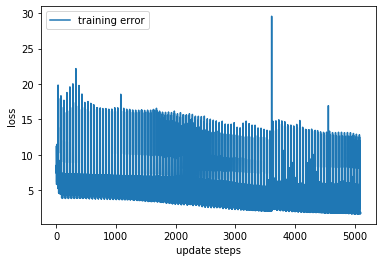

In [11]:
from matplotlib import pyplot as plt
pickle_in = open("/content/drive/My Drive/DLSP/result_from_final_model_update_loss_valid_loss-2.pickle","rb")
train_u = pickle.load(pickle_in)
plt.plot([i for i in range(0,len(train_u))],train_u,label="training error")
plt.xlabel("update steps")
plt.ylabel("loss")
plt.legend()
plt.show()
